In [14]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from mintpy.utils import readfile, utils as ut 
from mintpy.objects import timeseries
import cartopy.crs as ccrs
from mintpy import view
import datetime
from operator import itemgetter 
import h5py
from scipy import interpolate
import matplotlib.dates as mdates
from minopy.find_short_baselines import get_baselines_dict
import matplotlib.colors as mcolors
from minopy.objects.invert_pixel import process_pixel 


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]



def get_dates_ts(proj_dir, points_lalo, refy, refx, reftype, win_s=5):
    from mintpy.objects import timeseries   
  
    tsStack = proj_dir + '/{}'.format('timeseries_ERA5_demErr.h5')
    gStack = '/Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5'
    atr = readfile.read_attribute(tsStack)
    coord = ut.coordinate(atr, gStack)
    stack_obj = timeseries(tsStack)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    ts = np.zeros([len(points_lalo), num_dates])
    
    for t, coord in enumerate(points_lalo):
    
        if reftype == 'lalo':
            dates, ts[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack, lookup_file=gStack, 
                                                      ref_lat=refy, ref_lon=refx, win_size=win_s, unit='mm', 
                                                      print_msg=True)[0:2]
        if reftype =='yx':
            dates, ts[t, :] = ut.read_timeseries_yx(coord[0], coord[1], tsStack, ref_y=refy, ref_x=refx, 
                                                    win_size=win_s, unit='mm', print_msg=True)[0:2]
    
        
    x_values = [date.timetuple().tm_yday for date in dates]
    x = np.zeros([len(x_values),1])
    m = 0
    for t, value in enumerate(x_values):
        x[t] = value
        if t > 0: 
            if value < x[t-1]:
                if value < x_values[t-1]:
                    m += 360
                    x[t] += m
                else:
                    x[t] += m
                
    x = [y - x[0] for y in x]
    return dates, x, ts



center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [16]:
def read_ds(proj_dir):
    velocity_file = proj_dir + '/geocoded_sub/geo_velocity.h5'
    velocity_file2 = proj_dir + '/geocoded_sub/geo_vel_2020.h5'
    geometry_file = proj_dir + '/geocoded_sub/geo_geometryRadar.h5'
    mask_file_t = proj_dir + '/geocoded_sub/geo_maskTempCoh.h5'
    latitude = readfile.read(geometry_file, datasetName='latitude')[0]
    longitude = readfile.read(geometry_file, datasetName='longitude')[0]
    
    
    mask = np.ones(latitude.shape, dtype=np.int8)
    

    velocity = readfile.read(velocity_file, datasetName='velocity')[0]
    velocity2 = readfile.read(velocity_file2, datasetName='velocity')[0]
    mask = readfile.read(mask_file_t, datasetName='mask')[0]
    
    vel = np.array(velocity[mask==1]*1000)
    vel2 = np.array(velocity2[mask==1]*1000)
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    
    return lat, lon, vel, vel2
    
    

In [25]:

points_lalo = np.array([(44.1053, -121.8506), 
                        (44.1481, -121.7866)]) 

reflat, reflon = 44.2156, -121.8190
reflat, reflon = 44.2127, -121.8205
reflat, reflon = 44.1850, -121.7083


prj_dir = '/Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115'

project_dirs = [prj_dir + '/single_reference',
                prj_dir + '/ministacks',
                prj_dir + '/delaunay_6',
                prj_dir + '/seq_2_annual']

data = [x + '/geocoded_sub/geo_velocity.h5' for x in project_dirs]


geom_file = prj_dir + '/single_reference/geometryRadar.h5'

bbox = '43.98 44.22 -121.9764 -121.668'   # attr_b['mintpy.subset.lalo'].split(',')
lat = [float(i) for i in bbox.split()[0:2]]
lon = [float(i) for i in bbox.split()[2::]]

#baselines, dates = get_baselines_dict(prj_dir + '/inputs/baselines')
out_dir = './out_figures'

In [18]:
#refx = 441
#refy = 334

geom_file = project_dirs[0] + '/geometryRadar.h5'

# referencing
for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    !reference_point.py $velfile -l $reflat -L $reflon --lookup $geom_file
    #!reference_point.py $velfile -x $refx -y $refy --lookup $geom_file

--------------------------------------------------
input reference point in lat/lon: (44.2127, -121.8205)
input reference point in y/x: (75, 4650)
--------------------------------------------------
updating data value without re-writing to a new file
update metadata
Done.
--------------------------------------------------
input reference point in lat/lon: (44.2127, -121.8205)
input reference point in y/x: (75, 4650)
--------------------------------------------------
updating data value without re-writing to a new file
update metadata
Done.
--------------------------------------------------
input reference point in lat/lon: (44.2127, -121.8205)
input reference point in y/x: (75, 4650)
--------------------------------------------------
updating data value without re-writing to a new file
update metadata
Done.
--------------------------------------------------
input reference point in lat/lon: (44.2127, -121.8205)
input reference point in y/x: (75, 4650)
----------------------------------

In [188]:
## geocodeing
#subset_lat = 44.00, 44.20
#subset_lon = -122, -121.72
#lat = [43.9, 44.30] 
#lon = [-122.0, -121.65]

boxx = '43.9 44.30 -122.0 -121.65'

shadow_mask = project_dirs[0] + '/shadow_mask.h5'
for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    tsfile = prj + '/timeseries_ERA5_demErr.h5'
    temp_coh = prj + '/temporalCoherence.h5'
    out_vel = prj + '/vel_2020.h5'
    #!timeseries2velocity.py $tsfile --start-date 20200101 -o $out_vel 
    #!mask.py $prj_dir/inverted/tempCoh_full -m $shadow_mask -o $temp_coh
    geocode_dir = prj + '/geocoded_sub'
    os.makedirs(geocode_dir, exist_ok=True)
    !geocode.py $out_vel -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185 -b $boxx
    !geocode.py $geom_file -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185 -b $boxx
    !geocode.py $velfile -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185 -b $boxx
    !geocode.py $temp_coh -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185 -b $boxx
    !generate_mask.py $geocode_dir/geo_temporalCoherence.h5 -m .5 -o $geocode_dir/geo_maskTempCoh.h5

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (43.900000399999996, 44.3, -122.0, -121.65000035)
output file row / column number: (2160, 1890)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/vel_2020.h5
update REF_LAT/LON/Y/X
--------------------------------------------------
grab dataset structure from ref_file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/vel_2020.h5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geocoded_sub/geo_vel_2020.h5 with w mode
create dataset  : velocity

write data in block [0, 2160, 0, 1890] to file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geocoded_sub/geo_velocity.h5
--------------------------------------------------
reading velocityStd in block (0, 0, 8215, 2077) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 5 segments ...
write data in block [0, 2160, 0, 1890] to file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geocoded_sub/geo_velocity.h5
time used: 00 mins 15.5 secs.

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (43.900000399999996, 44.3, -122.0, -121.65000035)
output file row / column number: (2160, 1890)
searching relevant box covering t

--------------------------------------------------
reading latitude           in block (0, 0, 8215, 2077) from geometryRadar.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 5 segments ...
write data in block [0, 2160, 0, 1890] to file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded_sub/geo_geometryRadar.h5
--------------------------------------------------
reading longitude          in block (0, 0, 8215, 2077) from geometryRadar.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 5 segments ...
write data in block [0, 2160, 0, 1890] to file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded_sub/geo_geometryRadar.h5
--------------------------------------------------
reading shadowMask         in block (0, 0, 8215, 2077) from geometryRadar.h5 ...
input source data is bool type, restrict fill_value to False.
nearest resampling with pyresample.kd_tree using 1 CPU cores in 5 segments

output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (43.900000399999996, 44.3, -122.0, -121.65000035)
output file row / column number: (2160, 1890)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5
--------------------------------------------------
grab dataset structure from ref_file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/delaunay_6/geocoded_sub/geo_geometryRadar.h5 with w mode
create dataset  : azimuthAngle       of float32                   in size of (2160, 1890)         with compression = lzf
create dataset  : height             of float32                   in size of (2160, 1890)         with compression = lzf
create dat

create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
delete exsited file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/delaunay_6/geocoded_sub/geo_maskTempCoh.h5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/delaunay_6/geocoded_sub/geo_maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (2160, 1890)         with compression=None
finished writing to /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/delaunay_6/geocoded_sub/geo_maskTempCoh.h5
time used: 00 mins 0.3 secs.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (43.900000399999996, 44.3, -122.0, -

--------------------------------------------------
reading velocity    in block (0, 0, 8215, 2077) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 5 segments ...
write data in block [0, 2160, 0, 1890] to file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/seq_2_annual/geocoded_sub/geo_velocity.h5
--------------------------------------------------
reading velocityStd in block (0, 0, 8215, 2077) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 5 segments ...
write data in block [0, 2160, 0, 1890] to file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/seq_2_annual/geocoded_sub/geo_velocity.h5
time used: 00 mins 16.4 secs.

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.00018518

In [94]:
## geocodeing
#subset_lat = 44.00, 44.20
#subset_lon = -122, -121.72
geom_file = prj_dir + '/single_reference/geometryRadar.h5'

for prj in project_dirs:
    #velfile = prj + '/velocity.h5'
    #tsfile = prj + '/timeseries_ERA5_demErr.h5'
    temp_coh = prj + '/temporalCoherence.h5'
    tshfile = prj + '/S1_IW2_115_0447_0449_20180101_XXXXXXXX_N43940_N44241_W122033_W121599.he5'
    out = prj + '/20200619_20210813.unw'
    !save_roipac.py $tshfile displacement-20200619_20210813 -o $out
    !save_roipac.py $tshfile displacement-20200607_20210807 -o $out


read displacement-20200619_20210813 from file /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/S1_IW2_115_0447_0449_20180101_XXXXXXXX_N43940_N44241_W122033_W121599.he5
converting range to phase
write file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/20200619_20210813.unw
write file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/20200619_20210813.unw.rsc
read displacement-20200607_20210807 from file /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/S1_IW2_115_0447_0449_20180101_XXXXXXXX_N43940_N44241_W122033_W121599.he5
converting range to phase
write file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/20200619_20210813.unw
write file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/20200619_20210813.unw.rsc
read displacement-20200619_20210813 from file /Volumes/SaraMNew/scratch/minopy_subsets/Three

In [23]:
## geocodeing

shadow_mask = project_dirs[0] + '/shadow_mask.h5'
for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    tsfile = prj + '/timeseries_ERA5_demErr.h5'
    temp_coh = prj + '/temporalCoherence.h5'
    #!mask.py $prj_dir/inverted/tempCoh_full -m $shadow_mask -o $temp_coh
    geocode_dir = prj + '/geocoded'
    os.makedirs(geocode_dir, exist_ok=True)
    !geocode.py $velfile -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !geocode.py $temp_coh -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !generate_mask.py $geocode_dir/geo_temporalCoherence.h5 -m .5 -o $geocode_dir/geo_maskTempCoh.h5

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (43.939777262363286, 44.240517702363285, -122.03218945529296, -121.59978248029296)
output file row / column number: (1624, 2335)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/velocity.h5
update REF_LAT/LON/Y/X
--------------------------------------------------
grab dataset structure from ref_file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/velocity.h5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geocoded/geo_velocity.h5 with w mo

write data in block [0, 1624, 0, 2335] to file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded/geo_temporalCoherence.h5
time used: 00 mins 7.8 secs.

input temporalCoherence file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded/geo_temporalCoherence.h5
read /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded/geo_temporalCoherence.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
delete exsited file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded/geo_maskTempCoh.h5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded/geo_maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (1624, 2335)         with compression=None
finished writing to /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/

--------------------------------------------------
resampling file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/seq_2_annual/temporalCoherence.h5
update REF_LAT/LON/Y/X
--------------------------------------------------
grab dataset structure from ref_file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/seq_2_annual/temporalCoherence.h5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/seq_2_annual/geocoded/geo_temporalCoherence.h5 with w mode
create dataset  : temporalCoherence of float32                   in size of (1624, 2335)         with compression = None
close  HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/seq_2_annual/geocoded/geo_temporalCoherence.h5
--------------------------------------------------
reading temporalCoherence in block (0, 0, 8215, 2077) from temporalCoherence.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 5 segments ...
write data in block [0, 162

view.py /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/mintpy/geo/geo_20200607_20210807.unw -m /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geo_mask.h5 --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u mm -c temperature --dem /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem --contour-step 400 --contour-smooth 0.0 --shade-az -45 --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 43.9 44.3 --sub-lon -122.0 -121.65 --noverbose --noreference --notitle --ref-lalo 44.2156 -121.819
Un-scalable display unit: mm
view.py /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/mintpy/geo/geo_20200619_20210813.unw -m /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geo_mask.h5 --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u mm -c temperature --dem /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSi

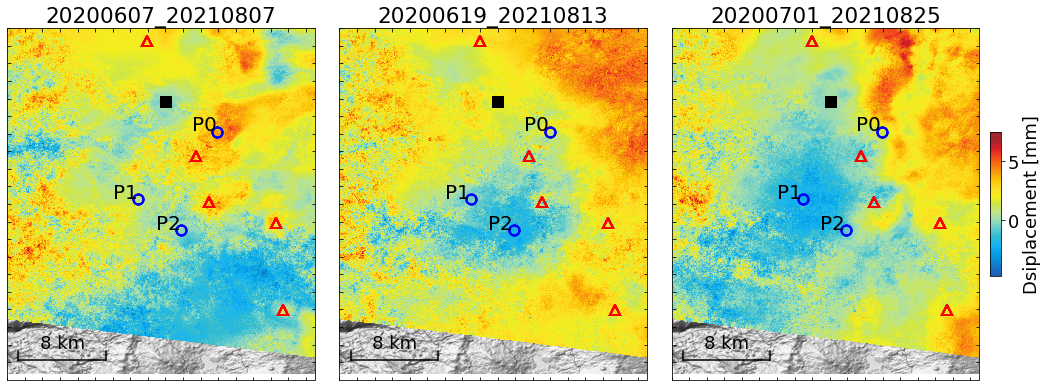

In [9]:
data = [x + '/20200619_20210813.unw' for x in project_dirs]
#data = [x + '/20200607_20210807.unw' for x in project_dirs]
mintpy_dir = '/Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/mintpy/geo'
data = [mintpy_dir + '/geo_20200607_20210807.unw ', mintpy_dir + '/geo_20200619_20210813.unw ', mintpy_dir + '/geo_20200701_20210825.unw ']
titles = ['20200607_20210807', '20200619_20210813', '20200701_20210825']
dem_file = os.path.expanduser('/Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem')


points_lalo1 = np.array([(44.1053, -121.8506), 
                        (43.9697, -121.7546)]) 

points_lalo = np.array([(44.1545, -121.7848),
                        (44.1024, -121.7700),
                        (44.0787, -121.6942),
                        (44.2851, -121.8405),
                        (43.9798, -121.6866)])  #volcanoes

points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.1053, -121.8506)]) 

points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.1053, -121.8506),
                        (44.0699, -121.8019)]) 

labels = ['North sister', 'South sister', 'Broken top']
labels1 = ['P0', 'P1', 'P2']


years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "18"


reflat, reflon = 43.9761, -121.6835
reflat, reflon = 44.1922, -121.6027
reflat, reflon = 44.1621, -121.6375
reflat, reflon = 44.1487, -121.8090
reflat, reflon = 44.1180, -121.9296
reflat, reflon = 44.1879, -121.7038
reflat, reflon = 44.2156, -121.8190

fsize = 12

#lat = [43.93987, 44.240425]
#lon = [-122.0321, -121.59986]


lat = [43.9, 44.30] 
lon = [-122.000, -121.65]
#dem_file = os.path.expanduser('/Users/Sara/Documents/insarlab/scratch/Ecuador/DEM/demLat_S02_N02_Lon_W080_W076.dem.wgs84')

factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 18 --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u mm -c temperature'
opt += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az -45 '.format(dem_file)
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
opt += ' --noverbose --noreference --notitle --ref-lalo {} {}'.format(reflat, reflon)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

maskfile =  '/Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geo_mask.h5'

for t in range(3):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} -m {}'.format(data[t], maskfile) + opt 
    #cmd += ' -v -{f} {f} '.format(f=5)
    #ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    ax.set_title(titles[t])

    for x in range(points_lalo.shape[0]):
       
        #ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, labels[x], fontsize=20, 
        #        horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], '^', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='r', markeredgewidth=2, transform=ccrs.PlateCarree())
        
        ax.plot(reflon, reflat, 's', markersize=10, markerfacecolor='k', 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        
    for x in range(points_lalo1.shape[0]):
       
        ax.text(points_lalo1[x,1]-0.001, points_lalo1[x,0]+0.002, labels1[x], fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo1[:,1], points_lalo1[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='b', markeredgewidth=2, transform=ccrs.PlateCarree())
    ax.set_title(titles[t])
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
#fig.colorbar(im, cax=cbar_ax, ticks=[-2,0,2], label='Dsiplacement [mm]')
fig.colorbar(im, cax=cbar_ax, label='Dsiplacement [mm]')
#fig.colorbar(im, cax=cbar_ax, label='Velocity (cm/yr)')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      

out_file = os.path.abspath(out_dir + '/ifg_Threesisters_mib.png')
#out_file = os.path.abspath(out_dir + '/20200607_20210807_ifg_Threesisters_mib.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

In [19]:
project_dirs = [prj_dir + '/single_reference',
                prj_dir + '/ministacks',
                prj_dir + '/delaunay_6',
                prj_dir + '/seq_2_annual']
lat = [43.9, 44.30] 
lon = [-122.0, -121.65]
latt, lonn, vel1_si, vel2_si = read_ds(project_dirs[0])
latt, lonn, vel1_mi, vel2_mi = read_ds(project_dirs[1])
latt, lonn, vel1_de, vel2_de = read_ds(project_dirs[2])
latt, lonn, vel1_se, vel2_se = read_ds(project_dirs[3])

view.py /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geocoded_sub/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 0.001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --dem /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem --contour-step 400 --contour-smooth 0.0 --shade-az -45 --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 43.9 44.3 --sub-lon -122.0 -121.65 --noverbose --notitle --ref-lalo 44.185 -121.7083 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded_sub/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 0.001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --dem /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem --contour-step 400 --contour-smooth 0.0 --shade-az -45 --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 43.9 44.3 --sub-lon -12

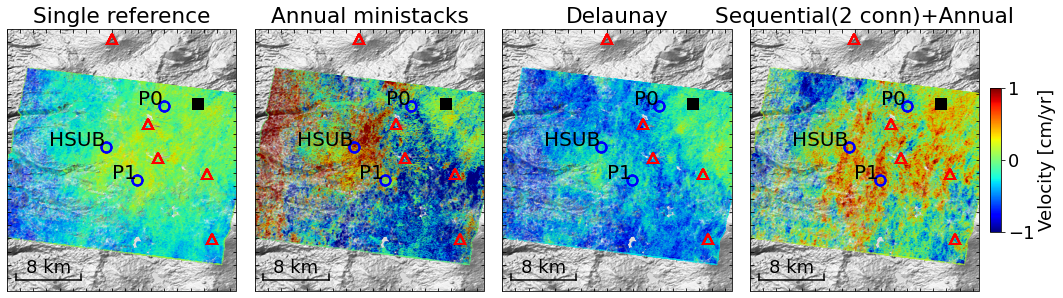

In [26]:
data = [x + '/geocoded_sub/geo_velocity.h5' for x in project_dirs]
#data = [x + '/geocoded_sub/geo_vel_2020.h5' for x in project_dirs]

dem_file = os.path.expanduser('/Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem')

points_lalo1 = np.array([(44.1053, -121.8506), 
                        (43.9697, -121.7546)]) 

points_lalo = np.array([(44.1545, -121.7848),
                        (44.1024, -121.7700),
                        (44.0787, -121.6942),
                        (44.2851, -121.8405),
                        (43.9798, -121.6866)])  #volcanoes

points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.1053, -121.8506)]) 

points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.1053, -121.8506),
                        (44.0699, -121.8019)]) 

points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.0699, -121.8019),
                        (44.120, -121.849)]) 

labels = ['North sister', 'South sister', 'Broken top']
labels1 = ['P0', 'P1', 'HSUB']

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "18"

titles = ['Single reference','Annual ministacks', 'Delaunay', 'Sequential(2 conn)+Annual']

reflat, reflon = 43.9761, -121.6835
reflat, reflon = 44.1922, -121.6027
reflat, reflon = 44.1621, -121.6375
#reflat, reflon = 44.1487, -121.8090
reflat, reflon = 44.1180, -121.9296
reflat, reflon = 44.1879, -121.7038
reflat, reflon = 44.2156, -121.8190
reflat, reflon = 44.1850, -121.7083

fsize = 12

#lat = [43.93987, 44.240425]
#lon = [-122.0321, -121.59986]

lat = [43.9, 44.30] 
lon = [-122.000, -121.65]

factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 18 --nocbar --alpha 0.001 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
opt += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az -45 '.format(dem_file)
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
opt += ' --noverbose  --notitle --ref-lalo {} {}'.format(reflat, reflon)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

ff = 1

for t in range(4):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity'.format(data[t]) + opt 
    cmd += ' -v -{f} {f} '.format(f=1)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    
    if t == 0:
        ax.scatter(lonn, latt, c=vel1_si/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 1:
        im1=ax.scatter(lonn, latt, c=vel1_mi/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 2:
        ax.scatter(lonn, latt, c=vel1_de/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    else:
        ax.scatter(lonn, latt, c=vel1_se/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        

    for x in range(points_lalo.shape[0]):
       
        #ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, labels[x], fontsize=20, 
        #        horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], '^', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='r', markeredgewidth=2, transform=ccrs.PlateCarree())
        
        ax.plot(reflon, reflat, 's', markersize=10, markerfacecolor='k', 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        
    for x in range(points_lalo1.shape[0]):
       
        ax.text(points_lalo1[x,1]-0.001, points_lalo1[x,0]+0.002, labels1[x], fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo1[:,1], points_lalo1[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='b', markeredgewidth=2, transform=ccrs.PlateCarree())
    ax.set_title(titles[t])
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1,0,1], label='Velocity [cm/yr]')
#fig.colorbar(im, cax=cbar_ax, label='Velocity (cm/yr)')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      


out_file = os.path.abspath(out_dir + '/4_velocity_Threesisters_mib.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

view.py /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/single_reference/geocoded_sub/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 0.001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --dem /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem --contour-step 400 --contour-smooth 0.0 --shade-az -45 --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 43.9 44.3 --sub-lon -122.0 -121.65 --noverbose --notitle --ref-lalo 44.185 -121.7083 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_subsets/ThreeSistersSenDT115/ministacks/geocoded_sub/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 0.001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --dem /Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem --contour-step 400 --contour-smooth 0.0 --shade-az -45 --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 43.9 44.3 --sub-lon -12

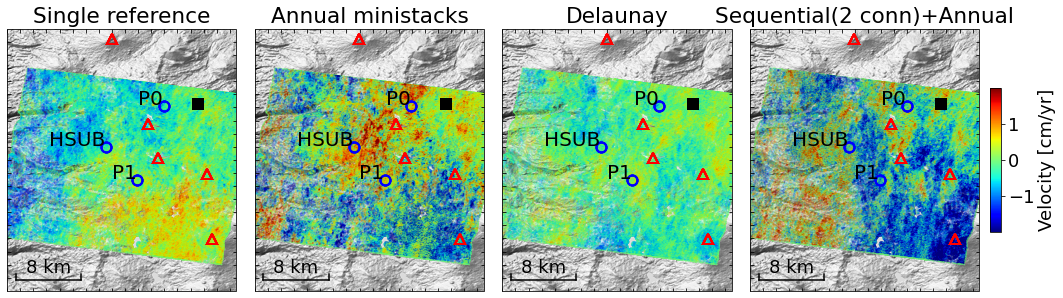

In [27]:
data = [x + '/geocoded_sub/geo_velocity.h5' for x in project_dirs]
#data = [x + '/geocoded_sub/geo_vel_2020.h5' for x in project_dirs]

dem_file = os.path.expanduser('/Volumes/SaraMNew/scratch/mintpy_subsets/ThreeSistersSenDT115/DEM/demLat_N43_N45_Lon_W124_W119.dem')

points_lalo1 = np.array([(44.1053, -121.8506), 
                        (43.9697, -121.7546)]) 

points_lalo = np.array([(44.1545, -121.7848),
                        (44.1024, -121.7700),
                        (44.0787, -121.6942),
                        (44.2851, -121.8405),
                        (43.9798, -121.6866)])  #volcanoes

points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.1053, -121.8506)]) 

points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.0699, -121.8019),
                        (44.120, -121.849)]) 

labels = ['North sister', 'South sister', 'Broken top']
labels1 = ['P0', 'P1', 'HSUB']

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "18"

titles = ['Single reference','Annual ministacks', 'Delaunay', 'Sequential(2 conn)+Annual']

reflat, reflon = 43.9761, -121.6835
reflat, reflon = 44.1922, -121.6027
reflat, reflon = 44.1621, -121.6375
#reflat, reflon = 44.1487, -121.8090
reflat, reflon = 44.1180, -121.9296
reflat, reflon = 44.1879, -121.7038
reflat, reflon = 44.2156, -121.8190
reflat, reflon = 44.1850, -121.7083

fsize = 12

#lat = [43.93987, 44.240425]
#lon = [-122.0321, -121.59986]

lat = [43.9, 44.30] 
lon = [-122.000, -121.65]

factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 18 --nocbar --alpha 0.001 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
opt += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az -45 '.format(dem_file)
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
opt += ' --noverbose  --notitle --ref-lalo {} {}'.format(reflat, reflon)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

ff = 2
for t in range(4):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity'.format(data[t]) + opt 
    cmd += ' -v -{f} {f} '.format(f=1)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    
    if t == 0:
        ax.scatter(lonn, latt, c=vel2_si/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 1:
        im1=ax.scatter(lonn, latt, c=vel2_mi/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 2:
        ax.scatter(lonn, latt, c=vel2_de/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    else:
        ax.scatter(lonn, latt, c=vel2_se/10, cmap='jet',  vmin=-ff, vmax=ff,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        

    for x in range(points_lalo.shape[0]):
       
        #ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, labels[x], fontsize=20, 
        #        horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], '^', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='r', markeredgewidth=2, transform=ccrs.PlateCarree())
        
        ax.plot(reflon, reflat, 's', markersize=10, markerfacecolor='k', 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        
    for x in range(points_lalo1.shape[0]):
       
        ax.text(points_lalo1[x,1]-0.001, points_lalo1[x,0]+0.002, labels1[x], fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo1[:,1], points_lalo1[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='b', markeredgewidth=2, transform=ccrs.PlateCarree())
    ax.set_title(titles[t])
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1,0,1], label='Velocity [cm/yr]')
#fig.colorbar(im, cax=cbar_ax, label='Velocity (cm/yr)')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      


out_file = os.path.abspath(out_dir + '/4_velocity_2020_Threesisters_mib.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

In [54]:
gps_file = './GPS_data/HUSB.tenv3.txt'
file1 = open(gps_file,"r") 
lines_husb = file1.readlines()
file1.close()


indx = np.hstack([1, np.arange(6,13), np.arange(14,17)]).astype(int)
gps_points_husb = []
for t in lines_husb:
        A = t.split()
        gps_points_husb.append(itemgetter(*indx)(A))
        

gps_file = './GPS_data/BEND.tenv3.txt'
file1 = open(gps_file,"r") 
lines_bend = file1.readlines()
file1.close()

indx = np.hstack([1, np.arange(6,13), np.arange(14,17)]).astype(int)
gps_points_bend = []
for t in lines_bend:
        A = t.split()
        gps_points_bend.append(itemgetter(*indx)(A))

        
xx_husb= [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_points_husb[1:]]
xx_bend = [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_points_bend[1:]]

first_date = datetime.datetime.strptime('18JAN01', '%y%b%d')
first_date = datetime.datetime.strptime('1901', '%y%b%d')

ind_h = np.min(np.where((np.array(xx_husb)-first_date)>datetime.timedelta(days=0))[0])
ind_b = np.min(np.where((np.array(xx_bend)-first_date)>datetime.timedelta(days=0))[0])
print(ind_h, ind_b)

xx_husb = xx_husb[ind_h::]
xx_bend = xx_bend[ind_b::]
gps_points_husb = gps_points_husb[ind_h:]
gps_points_bend = gps_points_bend[ind_b:]

m1, m2 = np.min(xx_husb), np.max(xx_husb)
h1,h2 = np.min(xx_bend), np.max(xx_bend)

val = np.max([m1,h1])
ind1_husb = xx_husb.index(val)
ind1_bend = xx_bend.index(val)

val = np.min([m2,h2])
ind2_husb = xx_husb.index(val)
ind2_bend = xx_bend.index(val)

xx_husb = xx_husb[ind1_husb:ind2_husb]
xx_bend = xx_bend[ind1_bend:ind2_bend]

xx_husb_d = [(x-xx_husb[0]).days for x in xx_husb]
xx_bend_d = [(x-xx_husb[0]).days for x in xx_bend]


E_husb = np.array([float(i[3])*100 for i in gps_points_husb[1:]])[ind1_husb:ind2_husb]
N_husb = np.array([float(i[5])*100 for i in gps_points_husb[1:]])[ind1_husb:ind2_husb]
U_husb = np.array([float(i[7])*100 for i in gps_points_husb[1:]])[ind1_husb:ind2_husb]
#dlos_minopy_husb = (N*np.sin(azangle_minopy) - E*np.cos(azangle_minopy))*np.sin(incangle_minopy) + U*np.cos(incangle_minopy)
#dlos_mintpy_husb = (N*np.sin(azangle_mintpy) - E*np.cos(azangle_mintpy))*np.sin(incangle_mintpy) + U*np.cos(incangle_mintpy)


E_bend = np.array([float(i[3])*100 for i in gps_points_bend[1:]])[ind1_bend:ind2_bend]
N_bend = np.array([float(i[5])*100 for i in gps_points_bend[1:]])[ind1_bend:ind2_bend]
U_bend = np.array([float(i[7])*100 for i in gps_points_bend[1:]])[ind1_bend:ind2_bend]


f = interpolate.interp1d(xx_bend_d, U_bend)
U_husb_intp = f(xx_husb_d)


5113 4288


In [28]:
points_lalo1 = np.array([(44.1822, -121.7608), 
                        (44.0699, -121.8019),
                        (44.120, -121.849)]) 

#reflat, reflon = 44.1879, -121.7038

dates_sr, x_sr, ts_sr = get_dates_ts(project_dirs[0], points_lalo1, reflat, reflon, 'lalo')  # single reference
dates_ms, x_ms, ts_ms = get_dates_ts(project_dirs[1], points_lalo1, reflat, reflon, 'lalo')  # mini stacks
dates_de, x_de, ts_de = get_dates_ts(project_dirs[2], points_lalo1, reflat, reflon, 'lalo')  # delaunay
dates_se, x_se, ts_se = get_dates_ts(project_dirs[3], points_lalo1, reflat, reflon, 'lalo')  # sequential

#for i, date in enumerate(dates):
#    if datetime.datetime.strptime(date, '%Y%m%d') not in dates_sr:
#        del dates[i]

input lat / lon: 44.1822 / -121.7608
corresponding y / x: 257 / 3070
input lat / lon: 44.0699 / -121.8019
corresponding y / x: 1181 / 3440
input lat / lon: 44.12 / -121.849
corresponding y / x: 836 / 4712
input lat / lon: 44.1822 / -121.7608
corresponding y / x: 257 / 3070
input lat / lon: 44.0699 / -121.8019
corresponding y / x: 1181 / 3440
input lat / lon: 44.12 / -121.849
corresponding y / x: 836 / 4712
input lat / lon: 44.1822 / -121.7608
corresponding y / x: 257 / 3070
input lat / lon: 44.0699 / -121.8019
corresponding y / x: 1181 / 3440
input lat / lon: 44.12 / -121.849
corresponding y / x: 836 / 4712
input lat / lon: 44.1822 / -121.7608
corresponding y / x: 257 / 3070
input lat / lon: 44.0699 / -121.8019
corresponding y / x: 1181 / 3440
input lat / lon: 44.12 / -121.849
corresponding y / x: 836 / 4712


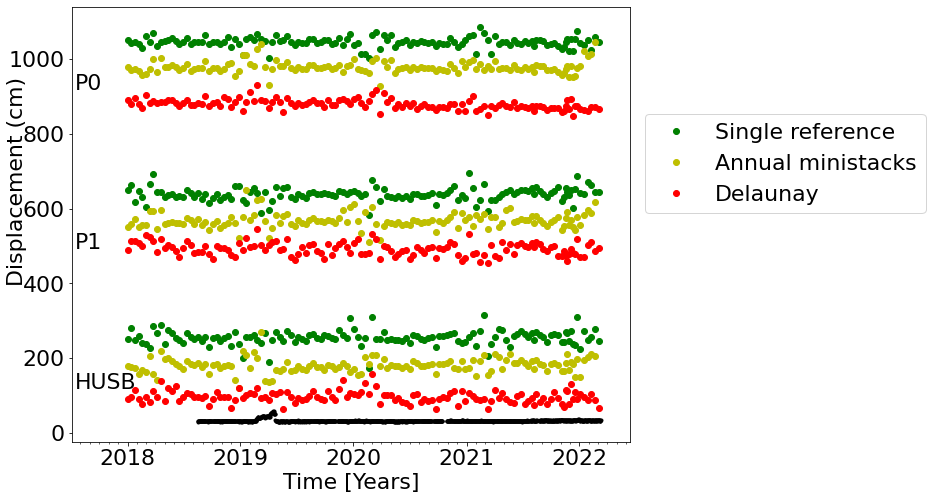

In [56]:
plt.rcParams["font.size"] = "22"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [250,180,100,10,0]
lsh = np.array([[250,180,90,10,0],
                [250,150,90,10,0],
               [250,180,90,10,0]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

msize = 15
fsize=8

shift = [800, 400, 0]

labels = ['Single reference','Annual ministacks', 'Delaunay'] #, 'Sequential(2 conn)+Annual']

ax1 = axs
#ax2 = ax1.twinx()

#bslines = np.array([baselines[x] for x in np.sort(dates)])

for t in range(len(points_lalo1)):
    ax1.plot(dates_sr, ts_sr[t, :] - ts_sr[t, 0] + lsh[t, 0]+ shift[t], 'go',markersize=6, linewidth=1)
    
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] + lsh[t, 1]+ shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] + lsh[t, 2]+ shift[t], 'ro',markersize=6,  linewidth=1)
    
    #ax1.plot(dates_se, ts_se[t, :] - ts_se[t, 0] + shifts[3]+ shift[t], 'mo',markersize=6,  linewidth=1)
        
    #ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    '''
    ax1.text(dates_ms[-1] + datetime.timedelta(days=20), 
             ts_ms[t, -1] - ts_ms[t, 0] + lsh[t,0]+ shift[t], 
             labels[0], color='g')
    
    ax1.text(dates_sr[-1] + datetime.timedelta(days=20), 
             ts_sr[t, -1] - ts_sr[t, 0] + lsh[t,1]+ shift[t], 
             labels[1], color='y')
    
    ax1.text(dates_de[-1] + datetime.timedelta(days=20), 
             ts_de[t, -1] - ts_de[t, 0] + lsh[t,2]+ shift[t], 
             labels[2], color='r')
    
    ax1.text(dates_se[-1] + datetime.timedelta(days=20), 
             ts_se[t, -1] - ts_se[t, 0] + lsh[t,3]+ shift[t], 
             labels[3], color='m')
    '''

    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()


ax1.plot(xx_husb, U_husb - U_husb_intp - (U_husb - U_husb_intp)[0]+30, '.', color='black')

ax1.text(dates_se[0]-datetime.timedelta(days=170) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se[0]-datetime.timedelta(days=170) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
ax1.text(dates_se[0]-datetime.timedelta(days=170) , (ts_sr[2, -1] - (ts_de[2, -1]))+ shifts[2]+shift[2], 'HUSB')
#ax1.text(dates_se[-1]+datetime.timedelta(days=20) , (ts_sr[t, -1] - (ts_de[t, -1]))*4*np.pi/56 + shift[2]-1, 'P2', size=20)

ax1.set_xlim(dates_se[0]-datetime.timedelta(days=180), dates_se[-1]+datetime.timedelta(days=100))
ax1.legend(labels, loc='lower right', bbox_to_anchor=(1.55,0.5))

#ax2.set_ylim(-60, 520)
#ax1.set_ylim(-150, 450)
#ax2.set_ylabel('Perp baseline \n(m)', color='blue')
#ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('Displacement (cm)')

ax1.set_xlabel('Time [Years]')

#ax2.set_yticks((-50, 0, 50, 100))
#ax1.set_yticks((0, 100, 200, 300, 400))
ax1.set_xticks((datetime.datetime(2018, 1, 1, 0, 0), 
                datetime.datetime(2019, 1, 1, 0, 0),
               datetime.datetime(2020, 1, 1, 0, 0),
               datetime.datetime(2021, 1, 1, 0, 0),
               datetime.datetime(2022, 1, 1, 0, 0)))
ax1.yaxis.set_label_coords(-0.08, 0.6)
#ax2.yaxis.set_label_coords(1.08, 0.18)

#plt.savefig(out_dir + '/3_Threesisters_timeseries_unwrap_compare.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


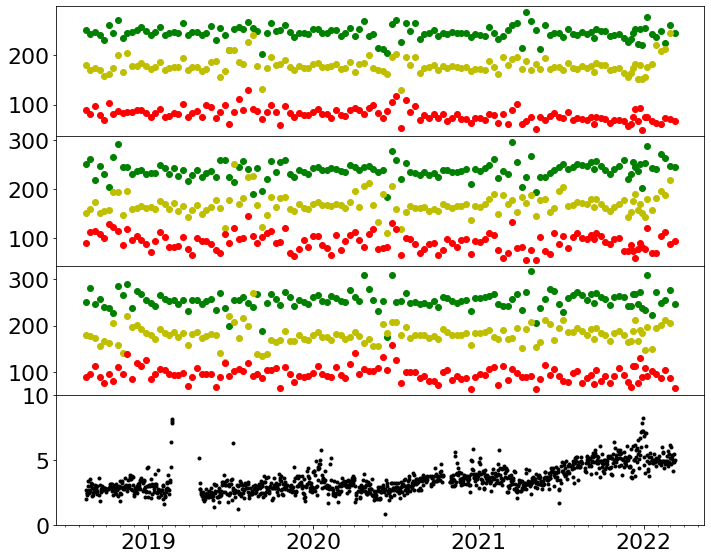

In [73]:
plt.rcParams["font.size"] = "22"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [250,180,100,10,0]
lsh = np.array([[250,180,90,10,0],
                [250,150,90,10,0],
               [250,180,90,10,0]])


fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

msize = 15
fsize=8

shift = [800, 400, 0]

points_name = ['P0', 'P1', 'HUSB']

labels = ['Single reference','Annual ministacks', 'Delaunay'] #, 'Sequential(2 conn)+Annual']

for t in range(len(points_lalo1)):
    ax1 = axs[t]
    ax1.plot(dates_sr, ts_sr[t, :] - ts_sr[t, 0] + lsh[t, 0], 'go',markersize=6, linewidth=1)
    
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] + lsh[t, 1], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] + lsh[t, 2], 'ro',markersize=6,  linewidth=1)
    
    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
    #ax1.text(dates_se[0]-datetime.timedelta(days=170) , (ts_sr[0, -1] - (ts_de[0, -1])), points_name[t])

ax1 = axs[3]
ax1.plot(xx_husb, U_husb - U_husb_intp - (U_husb - U_husb_intp)[0] + 2, '.', color='black')
ax1.set_ylim(0, 10)
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)
ax1.autoscale_view()

fig.subplots_adjust(wspace=0.08, hspace=-0, left=0.05, right=0.95, top=0.95, bottom=0.05)      

'''
#ax1.text(dates_se[0]-datetime.timedelta(days=170) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
#ax1.text(dates_se[0]-datetime.timedelta(days=170) , (ts_sr[2, -1] - (ts_de[2, -1]))+ shifts[2]+shift[2], 'HUSB')
#ax1.text(dates_se[-1]+datetime.timedelta(days=20) , (ts_sr[t, -1] - (ts_de[t, -1]))*4*np.pi/56 + shift[2]-1, 'P2', size=20)

ax1.set_xlim(dates_se[0]-datetime.timedelta(days=180), dates_se[-1]+datetime.timedelta(days=100))
ax1.legend(labels, loc='lower right', bbox_to_anchor=(1.55,0.5))

#ax2.set_ylim(-60, 520)
#ax1.set_ylim(-150, 450)
#ax2.set_ylabel('Perp baseline \n(m)', color='blue')
#ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('Displacement (cm)')

ax1.set_xlabel('Time [Years]')

#ax2.set_yticks((-50, 0, 50, 100))
#ax1.set_yticks((0, 100, 200, 300, 400))
ax1.set_xticks((datetime.datetime(2018, 1, 1, 0, 0), 
                datetime.datetime(2019, 1, 1, 0, 0),
               datetime.datetime(2020, 1, 1, 0, 0),
               datetime.datetime(2021, 1, 1, 0, 0),
               datetime.datetime(2022, 1, 1, 0, 0)))
ax1.yaxis.set_label_coords(-0.08, 0.6)
#ax2.yaxis.set_label_coords(1.08, 0.18)

#plt.savefig(out_dir + '/3_Threesisters_timeseries_unwrap_compare.png', bbox_inches='tight', transparent=True, dpi=300)
'''
plt.show()


In [58]:
tsStack_minopy = project_dirs[0] + '/timeseries_ERA5_demErr.h5'
gStack_minopy = project_dirs[0] + '/inputs/geometryRadar.h5'

attr_minopy = readfile.read_attribute(tsStack_minopy)

coord_minopy = ut.coordinate(attr_minopy, gStack_minopy)

# P1
yg_minopy1, xg_minopy1 = coord_minopy.geo2radar(points_lalo1[0][0], points_lalo1[0][1])[0:2]
vec_refined_1, temp_quality_1, coh_mat_1, shp_1, amp_1, data_1, col0_1, row0_1 = process_pixel((yg_minopy1, xg_minopy1), prj_dir + '/slcStack.h5')

# P2
yg_minopy2, xg_minopy2 = coord_minopy.geo2radar(points_lalo1[1][0], points_lalo1[1][1])[0:2]
vec_refined_2, temp_quality_2, coh_mat_2, shp_2, amp_2, data_2, col0_2, row0_2 = process_pixel((yg_minopy2, xg_minopy2), prj_dir + '/slcStack.h5')

# P2
yg_minopy3, xg_minopy3 = coord_minopy.geo2radar(points_lalo1[2][0], points_lalo1[2][1])[0:2]
vec_refined_3, temp_quality_3, coh_mat_3, shp_3, amp_3, data_3, col0_3, row0_3 = process_pixel((yg_minopy3, xg_minopy3), prj_dir + '/slcStack.h5')




(100, 100)
0.5565361327067165
(100, 100)
0.4938234149180024
(100, 100)
0.31542978702481206


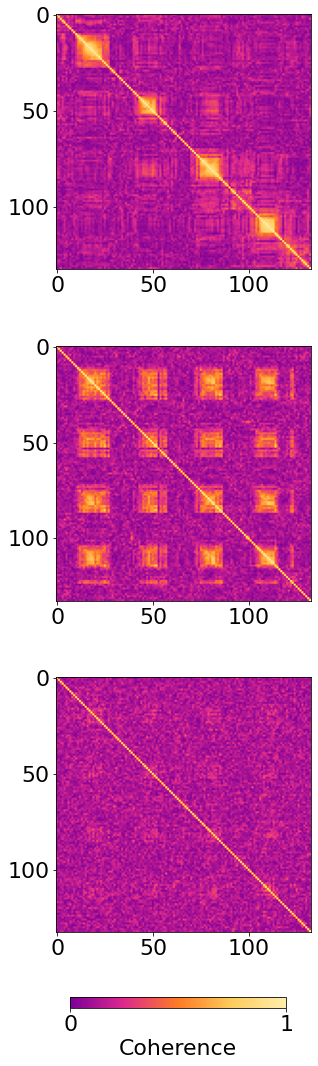

In [59]:
plt.rcParams["font.size"] = "22"
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

ax = axs[0]
im=ax.imshow(np.abs(np.array(coh_mat_1)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[1]
ax.imshow(np.abs(np.array(coh_mat_2)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[2]
ax.imshow(np.abs(np.array(coh_mat_3)), vmin=0, vmax=1, cmap=cmapc)


cbar_ax2 = fig.add_axes([0.42, 0.03, 0.2, 0.01])
#cbar_ax2 = fig.add_axes([0.5, 0.01, 0.005, 0.15, ])
fig.colorbar(im, cax=cbar_ax2, ticks=[0, 1], label='Coherence', orientation='horizontal')
fig.subplots_adjust(wspace=0.1, hspace=0.3, left=0.1, right=0.95, top=0.95, bottom=0.1)      

plt.savefig(out_dir + '/3_Threesisters_timeseries_unwrap_compare_coh_matrix.png', bbox_inches='tight', transparent=True, dpi=300)
